# DATA PREPROCESSING AND FEATURE ENGINEERING

### SETUP
<hr>

In [13]:
import pandas as pd
import numpy as np
import random 
import itertools 
from zipfile import ZipFile, Path

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

### GET DATA
<hr>

In [14]:
def get_data():
    with ZipFile("covtype.zip") as myzip:
        data = myzip.open("covtype.csv")
        df = pd.read_csv(data)

    return df

In [15]:
###### TODO: Investigate a better way to do this. ######

def reverse_encode(relevant_subset):
    '''
    This function reverses one-hot encoding for into rank-encoded representations
    Parameters: an subset of relevant columns of the same type, which we are trying to reverse encode
    Output: a title-less list of the encoded variable in numerical data
    '''

    num_list =[]
    for i in relevant_subset.iloc:
        ix = 1
        for j in i:
            if j ==1:
                num_list.append(ix)
            else: 
                ix +=1
                
    print('The new list has the following elements: ' + str(set(num_list)))
    if relevant_subset.shape[0] == len(num_list):
        return num_list
    else: print('Error in compiling list: lengths of the two lists do not match.')


In [16]:
tree_df = get_data() # instantiate are tree datafrime
soil_df = tree_df.loc[:,'Soil_Type1':'Soil_Type40'] # define our soul subset dataframe
wilderness_df = tree_df.loc[:,'Wilderness_Area1':'Wilderness_Area4'] # define our wilderness subset dataframe
cont_df = tree_df.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points'] # dataframe of remaining, continuous variables

In [17]:
# reverse one-hot-encode our soil and wilderness dataframes
w = reverse_encode(wilderness_df)
s = reverse_encode(soil_df)

The new list has the following elements: {1, 2, 3, 4}
The new list has the following elements: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}


In [18]:
# add our new features to the remaining, continuous varaiables dataframe
cont_df['Wilderness'] = w
cont_df['SoilType'] = s

forest_df = cont_df
print(forest_df.head())

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238   

<ipython-input-18-19c930b3bb52>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_df['Wilderness'] = w
<ipython-input-18-19c930b3bb52>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_df['SoilType'] = s


In [19]:
# scale our data (subtract mean and divide by standard deviation)
X_forest = preprocessing.scale(forest_df.values)

# combine our data so that we can split into train, test, val
X_forest_df = pd.DataFrame(X_forest, columns=[forest_df.columns])
X_forest_df['cov_type'] = tree_df.values[:, -1]
XY_forest_df = X_forest_df
print(XY_forest_df.shape)

(581012, 13)


In [20]:
# - split to train, val, test (70, 20, 10)
train, remainder = train_test_split(XY_forest_df, train_size=0.7)
val, test = train_test_split(remainder, test_size=0.33)

print(train.shape)
print(val.shape)
print(test.shape)

(406708, 13)
(116783, 13)
(57521, 13)


In [21]:
# convert each dataset to csv and compress
train.to_csv('../train.zip', compression = dict(method='zip', archive_name='train.csv'))
val.to_csv('../val.zip', compression = dict(method='zip', archive_name='val.csv'))
test.to_csv('../test.zip', compression = dict(method='zip', archive_name='test.csv'))

In [22]:
##### something like this will be used to access our data during model building #####
# with ZipFile("../train.zip") as myzip:
#     data = myzip.open("train.csv")
#     df = pd.read_csv(data)
#     df.drop(column=[0], axis = 1, inplace = True)
    
#     print(df)

### FEATURE SELECTION
<hr>

##### Get our datasets

In [23]:
with ZipFile("../train.zip") as myzip:
    data = myzip.open("train.csv")
    train_df = pd.read_csv(data)
    train_df.drop(train_df.columns[0], axis = 1, inplace = True)
    
with ZipFile("../val.zip") as myzip:
    data = myzip.open("val.csv")
    val_df = pd.read_csv(data)
    val_df.drop(val_df.columns[0], axis = 1, inplace = True)

with ZipFile("../test.zip") as myzip:
    data = myzip.open("test.csv")
    test_df = pd.read_csv(data)
    test_df.drop(test_df.columns[0], axis = 1, inplace = True)
    

In [24]:
x_train = train_df.values[:, :-1]
y_train  = train_df.values[:, -1]
x_val = val_df.values[:, :-1]
y_val  = val_df.values[:, -1]
x_test = test_df.values[:, :-1]
y_test  = test_df.values[:, -1]

##### Build random forest to get list of feature importance

In [25]:
# make a random forest model
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_val)
rf_acc = accuracy_score(rf_pred, y_val)

feat_rf = rf.feature_importances_
print("Our random forest classified {:0.2f}% of the of the trees correctly".format(rf_acc*100))


Our random forest classified 96.03% of the of the trees correctly


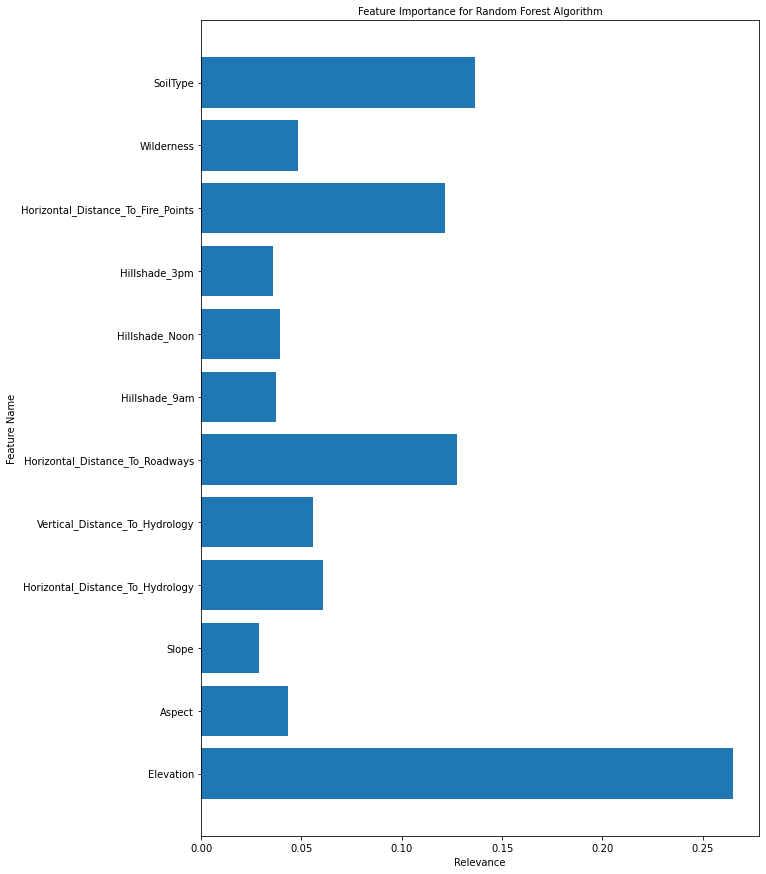

In [26]:
#plot feature importance
plt.figure(figsize=(10,15))
plt.barh(train_df.drop(columns='cov_type').columns.values, feat_rf)
plt.title('Feature Importance for Random Forest Algorithm',fontsize=10)
plt.ylabel('Feature Name')
plt.xlabel('Relevance')
plt.show()



A bar chart showing how important the random forest algorithm found the features in making predictions.

##### Perform Correlation Analysis

<AxesSubplot:xlabel='None', ylabel='None'>

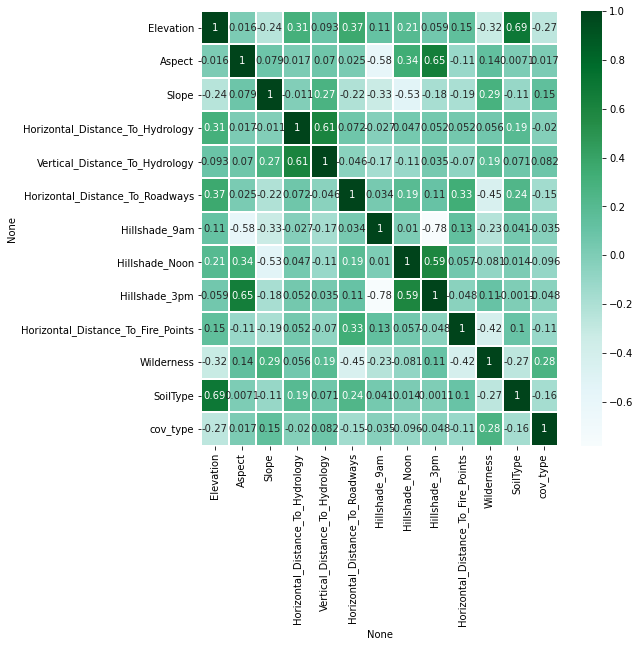

In [27]:
correlation = XY_forest_df.corr()

plt.figure(figsize=(8,8))

sns.heatmap(correlation,
            cmap='BuGn',
            linecolor='white',
            linewidths=1,
            annot=True, 
            xticklabels = True,
            yticklabels= True)


### CONCLUSIONS AND RECOMMENDATIONS
<hr>

When looking at the features’ correlation and relevance to the model, we recommend dropping column 'Hillshade_3pm’.  Our reasoning is:

1. The variable is strongly correlated with 'Hillshade_Noon' and the Aspect column. Therefore we feel like this additional feature will not bring additional information and increase the complexity of the model
2. The variable has low relevance to the model

##### Check to see if model performance increased after feature selection

In [28]:
train_df2 = train_df.drop(columns='Hillshade_3pm')
val_df2 = val_df.drop(columns='Hillshade_3pm')
test_df2 = test_df.drop(columns='Hillshade_3pm')

x_train2 = train_df2.values[:, :-1]
y_train2  = train_df2.values[:, -1]
x_val2 = val_df2.values[:, :-1]
y_val2  = val_df2.values[:, -1]
x_test2 = test_df2.values[:, :-1]
y_test2  = test_df2.values[:, -1]

rf2 = RandomForestClassifier()
rf2.fit(x_train2, y_train2)
rf_pred2 = rf2.predict(x_val2)
rf_acc2 = accuracy_score(rf_pred2, y_val2)

print("Our random forest classified {:0.2f}% of the of the trees correctly".format(rf_acc2*100))

Our random forest classified 96.22% of the of the trees correctly


After removing the 'Hillshade_3pm’ feature, the model increased its accuracy by .18pp.